<a href="https://colab.research.google.com/github/borisdayma/dalle-mini/blob/fix-colab/dev/inference/inference_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DALL·E mini - Inference pipeline

*Generate images from a text prompt*

<img src="https://github.com/borisdayma/dalle-mini/blob/main/img/logo.png?raw=true" width="200">

This notebook illustrates [DALL·E mini](https://github.com/borisdayma/dalle-mini) inference pipeline.

Just want to play? Use [the demo](https://huggingface.co/spaces/flax-community/dalle-mini) (temporarily in beta on Huging Face Spaces but soon to be open to all).

For more understanding of the model, refer to [the report](https://wandb.ai/dalle-mini/dalle-mini/reports/DALL-E-mini--Vmlldzo4NjIxODA).

## Install dependencies

In [ ]:
!pip install -q transformers flax
!pip install -q git+https://github.com/patil-suraj/vqgan-jax.git  # VQGAN model in JAX
!git clone https://github.com/borisdayma/dalle-mini  # Model files
%cd dalle-mini/

## Generate encoded images

We generate prediction samples from a text prompt using `flax-community/dalle-mini` model.

In [2]:
from dalle_mini.model import CustomFlaxBartForConditionalGeneration
from transformers import BartTokenizer
import jax
import random
from tqdm.notebook import tqdm, trange

In [3]:
# make sure we use compatible versions
DALLE_REPO = 'flax-community/dalle-mini'
DALLE_COMMIT_ID = '4d34126d0df8bc4a692ae933e3b902a1fa8b6114'

In [ ]:
# set up tokenizer and model
tokenizer = BartTokenizer.from_pretrained(DALLE_REPO, revision=DALLE_COMMIT_ID)
model = CustomFlaxBartForConditionalGeneration.from_pretrained(DALLE_REPO, revision=DALLE_COMMIT_ID)

In [5]:
# set a prompt
prompt = 'picture of a waterfall under the sunset'

In [6]:
# tokenize the prompt
tokenized_prompt = tokenizer(prompt, return_tensors='jax', padding='max_length', truncation=True, max_length=128)
tokenized_prompt

{'input_ids': DeviceArray([[    0, 37587,     9,    10, 35076,   223,     5, 18820,
                  2,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
      

Notes:

* `0`: BOS, special token representing the beginning of a sequence
* `2`: EOS, special token representing the end of a sequence
* `1`: special token representing the padding of a sequence when requesting a specific length

In [7]:
n_predictions = 8

# create random keys
seed = random.randint(0, 2**32-1)
key = jax.random.PRNGKey(seed)
subkeys = jax.random.split(key, num=n_predictions)
subkeys

DeviceArray([[1679594416, 3621619607],
             [ 683648130, 1222376564],
             [ 477828542,   85953127],
             [2933775019, 3039550240],
             [2121268409, 3674990845],
             [3532575719, 1626502976],
             [ 474735083,  347196755],
             [ 850661141, 3791838658]], dtype=uint32)

In [8]:
# generate sample predictions
encoded_images = [model.generate(**tokenized_prompt, do_sample=True, num_beams=1, prng_key=subkey) for subkey in tqdm(subkeys)]
encoded_images[0]

FlaxSampleOutput([('sequences',
                   DeviceArray([[16384,  5495,  2683,  5238,  5305, 10089,   129, 15189,
                                  9570,  1936,  4942,  7656, 10895, 14476,  4903, 14248,
                                  1536, 10121, 14059, 14494,  2920,  3342,  6882,  9753,
                                  9756,  6756,  4460, 15276,  9957,  4460, 16279,  2572,
                                  1635,  1948,  1704,  5098,  6386,  9345, 11927,  4135,
                                  9837,  8269,  5410,  1464,   112, 13370,  5693,  3804,
                                  3037,  6598, 14416,  8717,  8928,  5588, 15729,   663,
                                 11110,  6464, 15430, 15729,  3042, 14853,  7516, 14164,
                                 11993,  9900,  8447, 10228, 13440,  8663,  6059, 12786,
                                  6628, 13427,  4460,  7542,  1270, 11927, 12541, 11307,
                                 14878,  1402,  1268,   602, 13440,  4644, 114

The first token (`16384`) is a special token representing the start of a sequence in the decoder (not part of the image codebook).

In [9]:
# remove first token (BOS)
encoded_images = [img.sequences[..., 1:] for img in encoded_images]
encoded_images[0]

DeviceArray([[ 5495,  2683,  5238,  5305, 10089,   129, 15189,  9570,
               1936,  4942,  7656, 10895, 14476,  4903, 14248,  1536,
              10121, 14059, 14494,  2920,  3342,  6882,  9753,  9756,
               6756,  4460, 15276,  9957,  4460, 16279,  2572,  1635,
               1948,  1704,  5098,  6386,  9345, 11927,  4135,  9837,
               8269,  5410,  1464,   112, 13370,  5693,  3804,  3037,
               6598, 14416,  8717,  8928,  5588, 15729,   663, 11110,
               6464, 15430, 15729,  3042, 14853,  7516, 14164, 11993,
               9900,  8447, 10228, 13440,  8663,  6059, 12786,  6628,
              13427,  4460,  7542,  1270, 11927, 12541, 11307, 14878,
               1402,  1268,   602, 13440,  4644, 11497, 11591,  3081,
              11574,  1872,  5885, 10627,   358, 12187,  4945, 12272,
              14247, 11811,  9213,  3742, 13543, 11543, 11147,  4075,
              10081,  7504, 10508,  2428,  1989,  2683,  2523,  6690,
               4839,

The generated images are now represented by 256 tokens.

In [10]:
encoded_images[0].shape

(1, 256)

## Decode images

The generated images need to be decoded with `flax-community/vqgan_f16_16384`.

In [11]:
from vqgan_jax.modeling_flax_vqgan import VQModel
import numpy as np
from PIL import Image

In [12]:
# make sure we use compatible versions
VQGAN_REPO = 'flax-community/vqgan_f16_16384'
VQGAN_COMMIT_ID = '90cc46addd2dd8f5be21586a9a23e1b95aa506a9'

In [13]:
# set up VQGAN
vqgan = VQModel.from_pretrained(VQGAN_REPO, revision=VQGAN_COMMIT_ID)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


In [14]:
# decode images
decoded_images = [vqgan.decode_code(encoded_image) for encoded_image in tqdm(encoded_images)]
decoded_images[0]

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.



DeviceArray([[[[ 0.4682501 ,  0.65879536,  0.72961915],
               [ 0.38020995,  0.58146393,  0.66478324],
               [ 0.40179208,  0.58315474,  0.69024706],
               ...,
               [ 0.34444088,  0.6081122 ,  0.8137175 ],
               [ 0.3650911 ,  0.64122057,  0.84143007],
               [ 0.38591397,  0.6816852 ,  0.887118  ]],

              [[ 0.32201296,  0.51581126,  0.662528  ],
               [ 0.34781972,  0.53841984,  0.6724214 ],
               [ 0.38645712,  0.5546616 ,  0.69665354],
               ...,
               [ 0.39674336,  0.6403809 ,  0.85015815],
               [ 0.38186678,  0.66853034,  0.84672666],
               [ 0.4176703 ,  0.6669407 ,  0.8913695 ]],

              [[ 0.32832265,  0.5440124 ,  0.7017157 ],
               [ 0.32428372,  0.517475  ,  0.6439219 ],
               [ 0.33854687,  0.52524334,  0.65023166],
               ...,
               [ 0.38539118,  0.63597584,  0.8395324 ],
               [ 0.38467133,  0.65045244

In [15]:
# normalize images
clipped_images = [img.squeeze().clip(0., 1.) for img in decoded_images]

In [16]:
# convert to image
images = [Image.fromarray(np.asarray(img * 255, dtype=np.uint8)) for img in clipped_images]

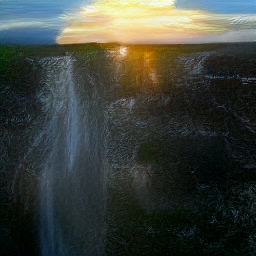

In [17]:
# display an image
images[0]

## Rank images with CLIP

We use `openai/clip-vit-base-patch32` to rank generated images against the prompt.

In [18]:
from transformers import CLIPProcessor, FlaxCLIPModel

In [ ]:
# set up model and processor
clip = FlaxCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

The CLIP processor tokenizes text and pre-processes images (resize to 224x224 and normalize) as required per the CLIP model.

In [20]:
# evaluate scores
inputs = processor(text=prompt, images=images, return_tensors='np')
logits = clip(**inputs).logits_per_image
scores = jax.nn.softmax(logits, axis=0).squeeze()  # normalize and sum all scores to 1

Prompt: picture of a waterfall under the sunset

Score: 0.8480912446975708


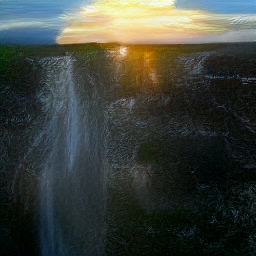


Score: 0.14368568360805511


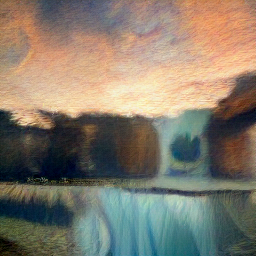


Score: 0.00663934089243412


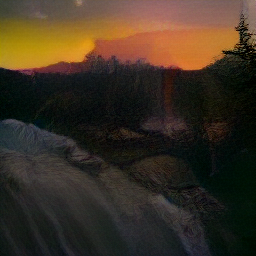


Score: 0.0008388907299377024


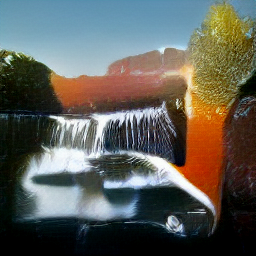


Score: 0.0004994343616999686


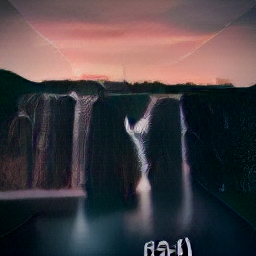


Score: 0.0001880008348962292


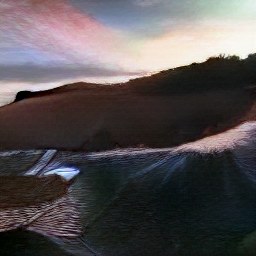


Score: 4.176010043011047e-05


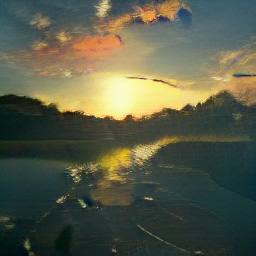


Score: 1.554006666992791e-05


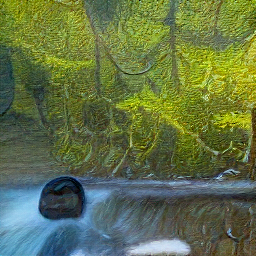

In [21]:
# rank images by score
print(f'Prompt: {prompt}\n')
for idx in scores.argsort()[::-1]:
    print(f'Score: {scores[idx]}')
    display(images[idx])
    print()

## Leverage JAX for faster inference

[JAX](https://github.com/google/jax) uses XLA to compile code to GPU/TPU, leading to faster inference.

Even with only 1 GPU, we can benefit from impressive speedups, even more after first inference (where the compilation happens).

In [22]:
from functools import partial
from flax.training.common_utils import shard
from flax.jax_utils import replicate

In [23]:
# check we can access TPU's or GPU's
jax.devices()

[GpuDevice(id=0, process_index=0)]

In [24]:
# replicate parameters on all devices
dalle_params = replicate(model.params)
vqgan_params = replicate(vqgan.params)

/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:387: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  "jax.host_count has been renamed to jax.process_count. This alias "
/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:374: UserWarning: jax.host_id has been renamed to jax.process_index. This alias will eventually be removed; please update your code.
  "jax.host_id has been renamed to jax.process_index. This alias "


In [25]:
# one set of inputs per device
prompt = ['picture of a waterfall under the sunset'] * jax.device_count()

In [26]:
# tokenize prompts and shard them across available devices
tokenized_prompt = tokenizer(prompt, return_tensors='jax', padding='max_length', truncation=True, max_length=128).data
tokenized_prompt = shard(tokenized_prompt)

We use `pmap` to compile the functions with XLA and perform operations in parallel on multiple devices.

In [27]:
# parallelize and compile functions

# function to generate encoded images
@partial(jax.pmap, axis_name="batch")
def p_generate(tokenized_prompt, key, params):
    return model.generate(
        **tokenized_prompt,
        do_sample=True,
        num_beams=1,
        prng_key=key,
        params=params
    )

# function to decode images
@partial(jax.pmap, axis_name="batch")
def p_decode(indices, params):
    return vqgan.decode_code(indices, params=params)

In [28]:
# generate images with compiled functions
n_predictions = 8
images = []

for i in trange(n_predictions // jax.device_count()):
    key, *subkeys = jax.random.split(key, jax.device_count() + 1)
    subkeys = jax.numpy.stack(subkeys)

    encoded_images = p_generate(tokenized_prompt, subkeys, dalle_params)
    encoded_images = encoded_images.sequences[..., 1:]

    decoded_images = p_decode(encoded_images, vqgan_params)
    decoded_images = decoded_images.clip(0., 1.).reshape((-1, 256, 256, 3))

    for img in decoded_images:
        images.append(Image.fromarray(np.asarray(img * 255, dtype=np.uint8)))

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.



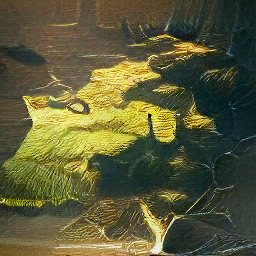

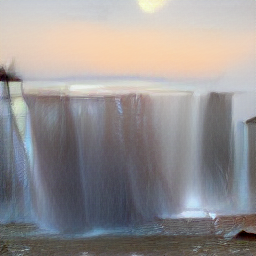

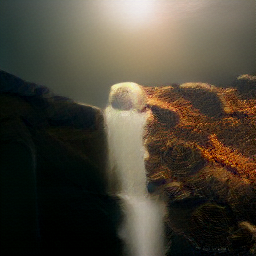

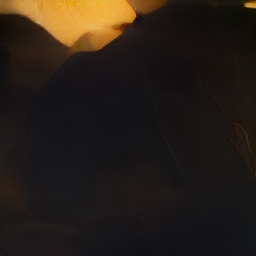

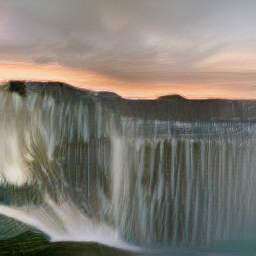

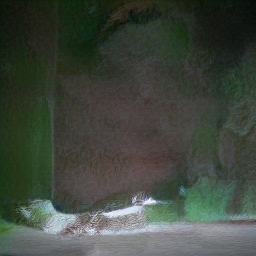

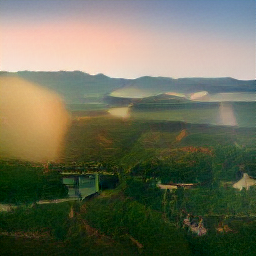

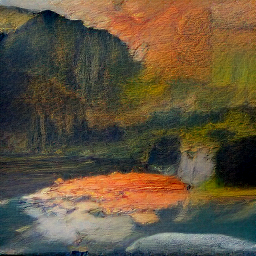

In [29]:
for img in images:
    display(img)
    print()